In [623]:
%%capture
!pip install tests

In [624]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

In [625]:
df_e = pd.read_csv('final_encoded.csv')

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:130: ValueWarning:

unknown kwargs ['weights']

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:130: ValueWarning:

unknown kwargs ['weights']



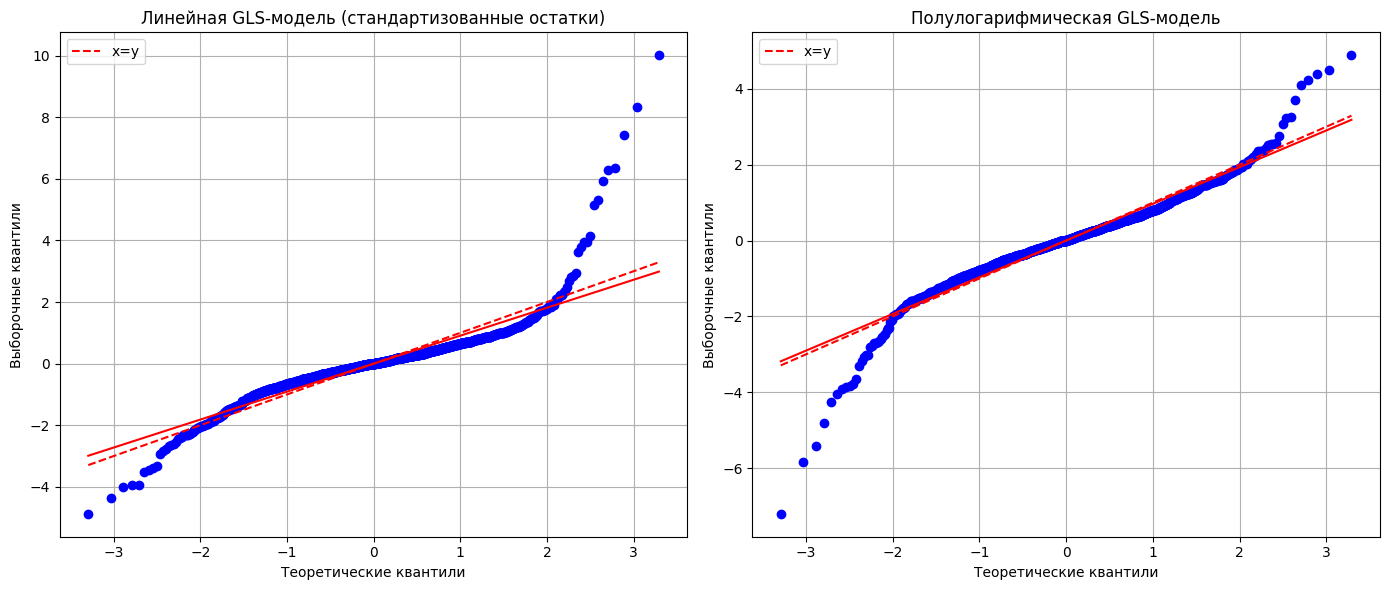

In [627]:
X = df_e.drop("price", axis=1)
y = df_e["price"]
y_log = np.log(y)

ols_model = sm.OLS(y, X).fit()
weights = 1 / (ols_model.resid ** 2 + 1e-6)

gls_model = sm.GLS(y, X, weights=weights).fit()
gls_log_model = sm.GLS(y_log, X, weights=weights).fit()

linear_resids = (y - gls_model.predict(X)) / gls_model.resid.std()
log_resids = (y_log - gls_log_model.predict(X)) / gls_log_model.resid.std()

# Построение графиков
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

def plot_qq(residuals, ax, title):
    (osm, osr), _ = stats.probplot(residuals, dist="norm", plot=ax)
    ax.plot(osm, osm, color='red', linestyle='--', label='x=y')
    ax.set_title(title)
    ax.set_xlabel("Теоретические квантили")
    ax.set_ylabel("Выборочные квантили")
    ax.legend()
    ax.grid(True)

plot_qq(linear_resids, axes[0], "Линейная GLS-модель (стандартизованные остатки)")

plot_qq(log_resids, axes[1], "Полулогарифмическая GLS-модель")

plt.tight_layout()
plt.show()

In [628]:
X = df_e.drop("price", axis=1)
y_linear = df_e["price"]

gls_model = sm.GLS(y, X).fit()
gls_log_model = sm.GLS(y_log, X).fit()

residuals_linear = gls_model.resid
residuals_log = gls_log_model.resid

def ks_test(residuals, model_name):
    residuals_standardized = (residuals - residuals.mean()) / residuals.std()

    # Тест Колмогорова-Смирнова
    ks_stat, p_value = stats.kstest(
        residuals_standardized,
        'norm',
        args=(0, 1)
    )

    print(f"Модель: {model_name}")
    print(f"Статистика K-S: {ks_stat:.4f}")
    print(f"P-значение: {p_value:.4f}")
    print("---")

# Проверка для обеих моделей
ks_test(residuals_linear, "Линейная модель")
ks_test(residuals_log, "Полулогарифмическая модель")


Модель: Линейная модель
Статистика K-S: 0.1065
P-значение: 0.0000
---
Модель: Полулогарифмическая модель
Статистика K-S: 0.0687
P-значение: 0.0000
---


In [629]:
df = pd.read_csv('final_encoded.csv')

In [630]:
# Создание модели
X = sm.add_constant(df.drop(columns='price')).values
y = df['price']
model = sm.OLS(y, X).fit()

# Ручной расчет DFFITS
residuals = y - model.predict(X)
h = np.diag(X @ np.linalg.inv(X.T @ X) @ X.T)  # Матрица шляпницы
p = X.shape[1]  # Количество параметров (включая константу)
n = len(y)

# Расчет стандартных ошибок
s_squared = np.sum(residuals**2) / (n - p)
s_i = np.sqrt(s_squared * (1 - h))

# Формула DFFITS
dffits = (residuals / s_i) * np.sqrt(h / (1 - h))

# Пороговое значение
dffits_threshold = 2 * np.sqrt(p / n)

# Фильтрация
non_outliers_mask = np.abs(dffits) <= dffits_threshold
data_filtered_no_outliers = df[non_outliers_mask].reset_index(drop=True)

print(f"Размер до фильтрации: {len(df)}")
print(f"Размер после фильтрации: {len(data_filtered_no_outliers)}")

Размер до фильтрации: 1390
Размер после фильтрации: 1150


<ipython-input-630-2cba5bdff33c>:14: RuntimeWarning:

invalid value encountered in sqrt

<ipython-input-630-2cba5bdff33c>:17: RuntimeWarning:

invalid value encountered in sqrt



In [631]:
import plotly.graph_objects as go

# Визуализация
fig = go.Figure()

# Точки DFFITS
fig.add_trace(go.Scatter(
    x=np.arange(len(dffits)),
    y=dffits,
    mode='markers',
    name='DFFITS',
    marker=dict(
        color=np.where(np.abs(dffits) > dffits_threshold, 'red', 'blue'),
        size=5,
        opacity=0.7
    ),
    hovertemplate="Наблюдение: %{x}<br>DFFITS: %{y:.3f}<extra></extra>"
))

# Пороговые линии
fig.add_hline(
    y=dffits_threshold,
    line_dash="dot",
    line_color="red",
    annotation_text=f"Верхний порог: {dffits_threshold:.2f}",
    annotation_position="top right"
)

fig.add_hline(
    y=-dffits_threshold,
    line_dash="dot",
    line_color="red",
    annotation_text=f"Нижний порог: {-dffits_threshold:.2f}",
    annotation_position="bottom right"
)

# Выделение выбросов
outliers = np.where(np.abs(dffits) > dffits_threshold)[0]
fig.add_trace(go.Scatter(
    x=outliers,
    y=dffits[outliers],
    mode='markers',
    marker=dict(
        color='red',
        size=8,
        symbol='x'
    ),
    name='Выбросы'
))

# Оформление
fig.update_layout(
    title='Анализ выбросов с помощью DFFITS',
    xaxis_title='Номер наблюдения',
    yaxis_title='DFFITS',
    hovermode='closest',
    showlegend=True,
    template='plotly_white',
    height=600,
    yaxis_range=[-4, 4],
)

fig.show()

In [632]:
data_filtered_no_outliers

,price,metro_time,info_total_area,floor_ratio,last_floor,district_ВАО,district_ЗАО,district_ЗелАО,district_НАО (Новомосковский),district_САО,...,rent_living_conditions_можно с детьми,rent_living_conditions_можно с детьми и животными,rent_living_conditions_можно с животными,"rent_living_conditions_ни с детьми, ни с животными",year_built_interval_1890-1917,year_built_interval_1917-1945,year_built_interval_1945-1970,year_built_interval_1970-1990,year_built_interval_1991-2025,year_built_interval_не попал
0,30000,9.0,40.0,0.333333,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,90000,5.0,43.0,0.291667,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,59900,9.0,29.2,0.791667,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,35000,4.0,36.7,0.333333,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,34000,16.0,21.6,0.555556,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,65000,9.0,52.0,0.083333,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1146,65000,5.0,27.0,0.133333,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1147,65000,24.0,35.7,0.636364,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1148,65000,6.0,40.0,0.636364,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:130: ValueWarning:

unknown kwargs ['weights']

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:130: ValueWarning:

unknown kwargs ['weights']



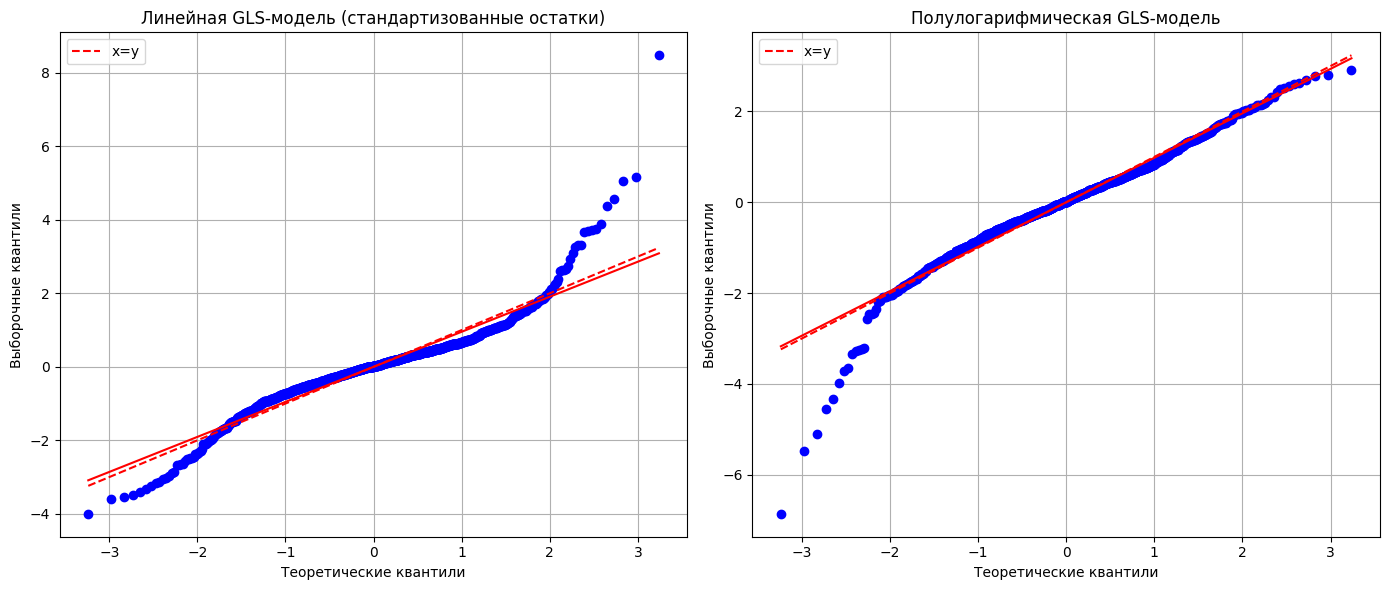

In [633]:
X = data_filtered_no_outliers.drop("price", axis=1)
y = data_filtered_no_outliers["price"]
y_log = np.log(y)

ols_model = sm.OLS(y, X).fit()
weights = 1 / (ols_model.resid ** 2 + 1e-6)

gls_model = sm.GLS(y, X, weights=weights).fit()
gls_log_model = sm.GLS(y_log, X, weights=weights).fit()

linear_resids = (y - gls_model.predict(X)) / gls_model.resid.std()  # <-- Стандартизация
log_resids = (y_log - gls_log_model.predict(X)) / gls_log_model.resid.std()

# Построение графиков
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Общая функция для построения QQ-plot
def plot_qq(residuals, ax, title):
    (osm, osr), _ = stats.probplot(residuals, dist="norm", plot=ax)
    ax.plot(osm, osm, color='red', linestyle='--', label='x=y')  # Линия x=y
    ax.set_title(title)
    ax.set_xlabel("Теоретические квантили")
    ax.set_ylabel("Выборочные квантили")
    ax.legend()
    ax.grid(True)

plot_qq(linear_resids, axes[0], "Линейная GLS-модель (стандартизованные остатки)")

# График для полулогарифмической модели
plot_qq(log_resids, axes[1], "Полулогарифмическая GLS-модель")

plt.tight_layout()
plt.show()

In [635]:
ks_test(log_resids, "Полулогарифмическая модель")

Модель: Полулогарифмическая модель
Статистика K-S: 0.0568
P-значение: 0.0011
---


In [636]:
def jarque_bera_test(residuals):
    n = len(residuals)
    skewness = stats.skew(residuals)
    kurtosis = stats.kurtosis(residuals, fisher=False)  # Fisher=False возвращает эксцесс Пирсона (kurtosis = E[(X-μ)^4]/σ^4 - 3)

    JB_stat = (n / 6) * (skewness**2 + (kurtosis - 3)**2 / 4)
    p_value = stats.chi2.sf(JB_stat, df=2)  # Распределение χ² с 2 степенями свободы

    return JB_stat, p_value

In [637]:
def shapiro_wilk_test(residuals):
    W_stat, p_value = stats.shapiro(residuals)
    return W_stat, p_value

In [638]:
jb_stat, jb_p = jarque_bera_test(log_resids)
sw_stat, sw_p = shapiro_wilk_test(log_resids)

print(f"Jarque-Bera Test: JB = {jb_stat:.2f}, p-value = {jb_p:.4f}")
print(f"Shapiro-Wilk Test: W = {sw_stat:.3f}, p-value = {sw_p:.4f}")

Jarque-Bera Test: JB = 945.19, p-value = 0.0000
Shapiro-Wilk Test: W = 0.957, p-value = 0.0000


In [868]:
df_new = pd.read_csv('final_encoded_with_district.csv')

In [869]:
area_dummy_columns = [col for col in df_new.columns if col.startswith('area_')]

df_new = df_new.drop(columns=area_dummy_columns)

In [870]:
area_dummy_columns = [col for col in df_new.columns if col.startswith('district_')]

df_new = df_new.drop(columns=area_dummy_columns)

In [871]:
df_new

,price,metro_time,info_total_area,floor_ratio,last_floor,rooms_1,rooms_2,rooms_3,rooms_4,rooms_студия,...,rent_living_conditions_можно с детьми,rent_living_conditions_можно с детьми и животными,rent_living_conditions_можно с животными,"rent_living_conditions_ни с детьми, ни с животными",year_built_interval_1890-1917,year_built_interval_1917-1945,year_built_interval_1945-1970,year_built_interval_1970-1990,year_built_interval_1991-2025,year_built_interval_не попал
0,470000,7.0,73.0,0.683333,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,270000,13.0,68.0,0.522727,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
2,30000,9.0,40.0,0.333333,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,75000,13.0,60.0,0.375000,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,29000,7.0,12.0,0.611111,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385,65000,5.0,27.0,0.133333,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1386,65000,24.0,35.7,0.636364,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1387,65000,6.0,40.0,0.636364,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1388,64000,7.0,22.0,0.333333,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0


In [872]:
df_new_2 = df_new

In [873]:
df_new_2['info_total_area_exp'] = np.log(df_new_2['info_total_area'])
df_new_2 = df_new_2.drop(columns=['info_total_area'])

In [874]:
df_new_2

,price,metro_time,floor_ratio,last_floor,rooms_1,rooms_2,rooms_3,rooms_4,rooms_студия,rent_jkh_включена (без счётчиков),...,rent_living_conditions_можно с детьми и животными,rent_living_conditions_можно с животными,"rent_living_conditions_ни с детьми, ни с животными",year_built_interval_1890-1917,year_built_interval_1917-1945,year_built_interval_1945-1970,year_built_interval_1970-1990,year_built_interval_1991-2025,year_built_interval_не попал,info_total_area_exp
0,470000,7.0,0.683333,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4.290459
1,270000,13.0,0.522727,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,4.219508
2,30000,9.0,0.333333,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,3.688879
3,75000,13.0,0.375000,0,0,1,0,0,0,1,...,0,0,1,0,0,1,0,0,0,4.094345
4,29000,7.0,0.611111,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,2.484907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385,65000,5.0,0.133333,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,1,0,3.295837
1386,65000,24.0,0.636364,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,3.575151
1387,65000,6.0,0.636364,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,3.688879
1388,64000,7.0,0.333333,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,1,0,3.091042


In [875]:
print(df_new.isnull().any().any())
#Пропуски
print(df_new.duplicated().sum().sum())
#Дубликаты

False
0


In [876]:
X_full = df_new_2.drop("price", axis=1)
y = df_new_2["price"]

model = sm.GLS(y, X_full).fit()

residuals_full = y - model.predict(X_full)
h_full = np.diag(np.dot(np.dot(X_full, np.linalg.inv(np.dot(X_full.T, X_full))), X_full.T))
s_squared = np.sum(residuals_full**2) / (len(y) - len(X_full.columns))
s_i = np.sqrt(s_squared * (1 - h_full))

dffits_full = (residuals_full / s_i) * np.sqrt(h_full / (1 - h_full))

threshold_full = 2 * np.sqrt(len(X_full.columns) / len(y))

non_outliers_mask = np.abs(dffits_full) <= threshold_full
data_filtered_no_outliers = df_new_2[non_outliers_mask].reset_index(drop=True)

original_size = len(df_new_2)
filtered_size = len(data_filtered_no_outliers)

print(f"Размер до фильтрации: {original_size}")
print(f"Размер после фильтрации: {filtered_size}")

Размер до фильтрации: 1390
Размер после фильтрации: 645


<ipython-input-876-e55fe2fbcb28>:11: RuntimeWarning:

invalid value encountered in sqrt



In [877]:
data_filtered_no_outliers

,price,metro_time,floor_ratio,last_floor,rooms_1,rooms_2,rooms_3,rooms_4,rooms_студия,rent_jkh_включена (без счётчиков),...,rent_living_conditions_можно с детьми и животными,rent_living_conditions_можно с животными,"rent_living_conditions_ни с детьми, ни с животными",year_built_interval_1890-1917,year_built_interval_1917-1945,year_built_interval_1945-1970,year_built_interval_1970-1990,year_built_interval_1991-2025,year_built_interval_не попал,info_total_area_exp
0,75000,13.0,0.375000,0,0,1,0,0,0,1,...,0,0,1,0,0,1,0,0,0,4.094345
1,34000,16.0,0.555556,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,1,0,3.072693
2,115000,9.0,0.700000,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,1,0,3.850148
3,25000,12.0,0.424242,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,3.496508
4,29999,5.0,0.052632,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,3.295837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,65000,11.0,0.800000,0,0,1,0,0,0,1,...,1,0,0,0,0,1,0,0,0,3.806662
641,65000,5.0,0.133333,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,1,0,3.295837
642,65000,24.0,0.636364,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,3.575151
643,64000,7.0,0.333333,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,1,0,3.091042


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:130: ValueWarning:

unknown kwargs ['weights']

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:130: ValueWarning:

unknown kwargs ['weights']



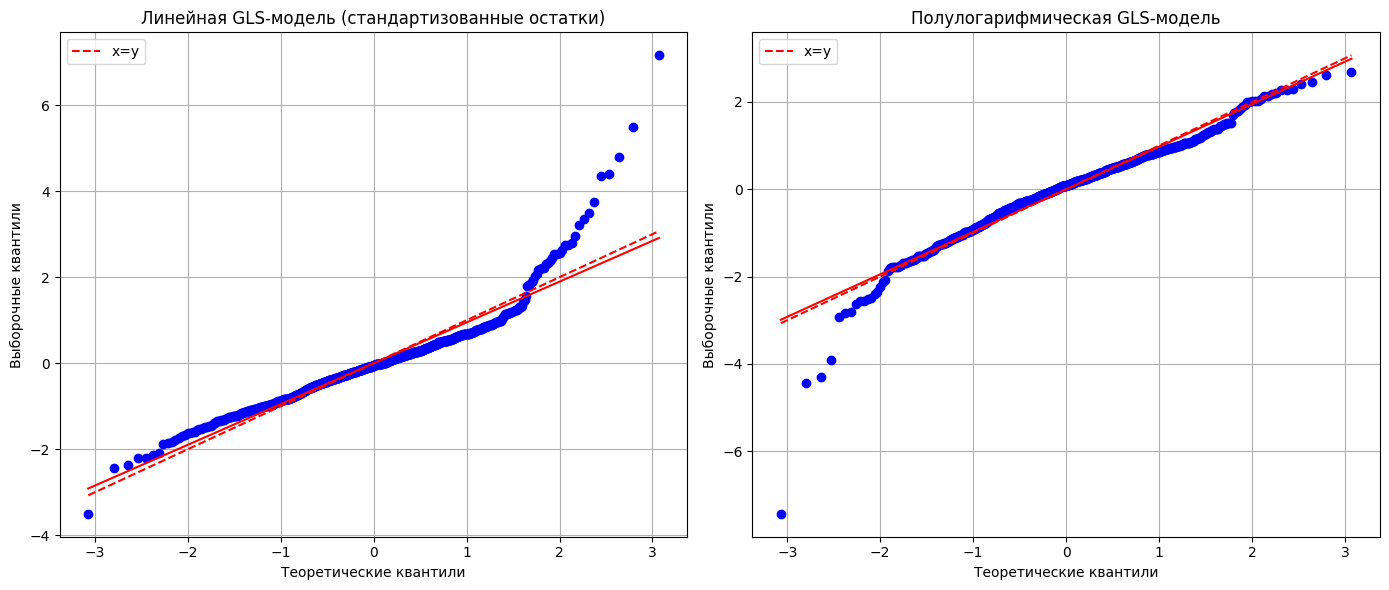

In [885]:
X = data_filtered_no_outliers.drop("price", axis=1)
y = data_filtered_no_outliers["price"]
y_log = np.log(y)

ols_model = sm.OLS(y, X).fit()
weights = 1 / (ols_model.resid ** 2 + 1e-6)

gls_model = sm.GLS(y, X, weights=weights).fit()
gls_log_model = sm.GLS(y_log, X, weights=weights).fit()

linear_resids = (y - gls_model.predict(X)) / gls_model.resid.std()  # <-- Стандартизация
log_resids = (y_log - gls_log_model.predict(X)) / gls_log_model.resid.std()  # Уже в логарифмической шкале

# Построение графиков
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Общая функция для построения QQ-plot
def plot_qq(residuals, ax, title):
    (osm, osr), _ = stats.probplot(residuals, dist="norm", plot=ax)
    ax.plot(osm, osm, color='red', linestyle='--', label='x=y')  # Линия x=y
    ax.set_title(title)
    ax.set_xlabel("Теоретические квантили")
    ax.set_ylabel("Выборочные квантили")
    ax.legend()
    ax.grid(True)

plot_qq(linear_resids, axes[0], "Линейная GLS-модель (стандартизованные остатки)")

# График для полулогарифмической модели
plot_qq(log_resids, axes[1], "Полулогарифмическая GLS-модель")

plt.tight_layout()
plt.show()

In [879]:
ks_test(linear_resids, "Линейная модель")

Модель: Линейная модель
Статистика K-S: 0.0940
P-значение: 0.0000
---


In [880]:
ks_test((y_log - gls_log_model.predict(X)), "Линейная модель")

Модель: Линейная модель
Статистика K-S: 0.0522
P-значение: 0.0577
---
